In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import util.data_proc as dp
import util.im_stats as imstat
import util.pipeline as pipe

import h5py

from sigpy.plot import ImagePlot, LinePlot

plt.rcParams['savefig.dpi']=300

# print("Num GPUs: {}".format(torch.cuda.device_count()))
torch.cuda.set_device(0)
print("Currently using GPU {}".format(torch.cuda.current_device()))

pre_run = True # Determines whether to use saved results or to rerun the network
acc_8 = True # Determines whether to run/display results for an acceleration factor of 8 (True) or 4 (False)

Currently using GPU 1


In [3]:
%matplotlib notebook

In [5]:
raw_file_path = "data/raw/fastmri/"
data_file = raw_file_path+"train/file1001999.h5" #Train
if acc_8:
    mask_file = raw_file_path+"test/file1000082.h5" #8x mask Test
else:
    mask_file = raw_file_path+"test/file1001187.h5" #4x mask Test

f1 = h5py.File(data_file, 'r')
f2 = h5py.File(mask_file, 'r')

# Get the data
ksp_data = np.array(f1[list(f1.keys())[1]])

recon_gt = np.array(f1[list(f1.keys())[2]])

mask = np.array(f2[list(f2.keys())[2]])

#The provided mask and data has last dim of 368, but the actual data is smaller (both are zero padded). However, to prevent forcing the network to learn outside the actual data region, we force the mask to 0 there
w = 330
assert w%2 == 0
mask[:mask.shape[-1]//2-w//2] = 0 
mask[mask.shape[-1]//2+w//2:] =0
mask = np.repeat(mask[None,:], ksp_data.shape[2], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask = np.pad(mask,((0,),((ksp_data.shape[-1]-mask.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up

print("Data shape (# Slices, # Coils, H, W): {}\nMask shape: {}".format(ksp_data.shape, mask.shape))

Data shape (# Slices, # Coils, H, W): (44, 15, 640, 368)
Mask shape: (640, 368)


<IPython.core.display.Javascript object>


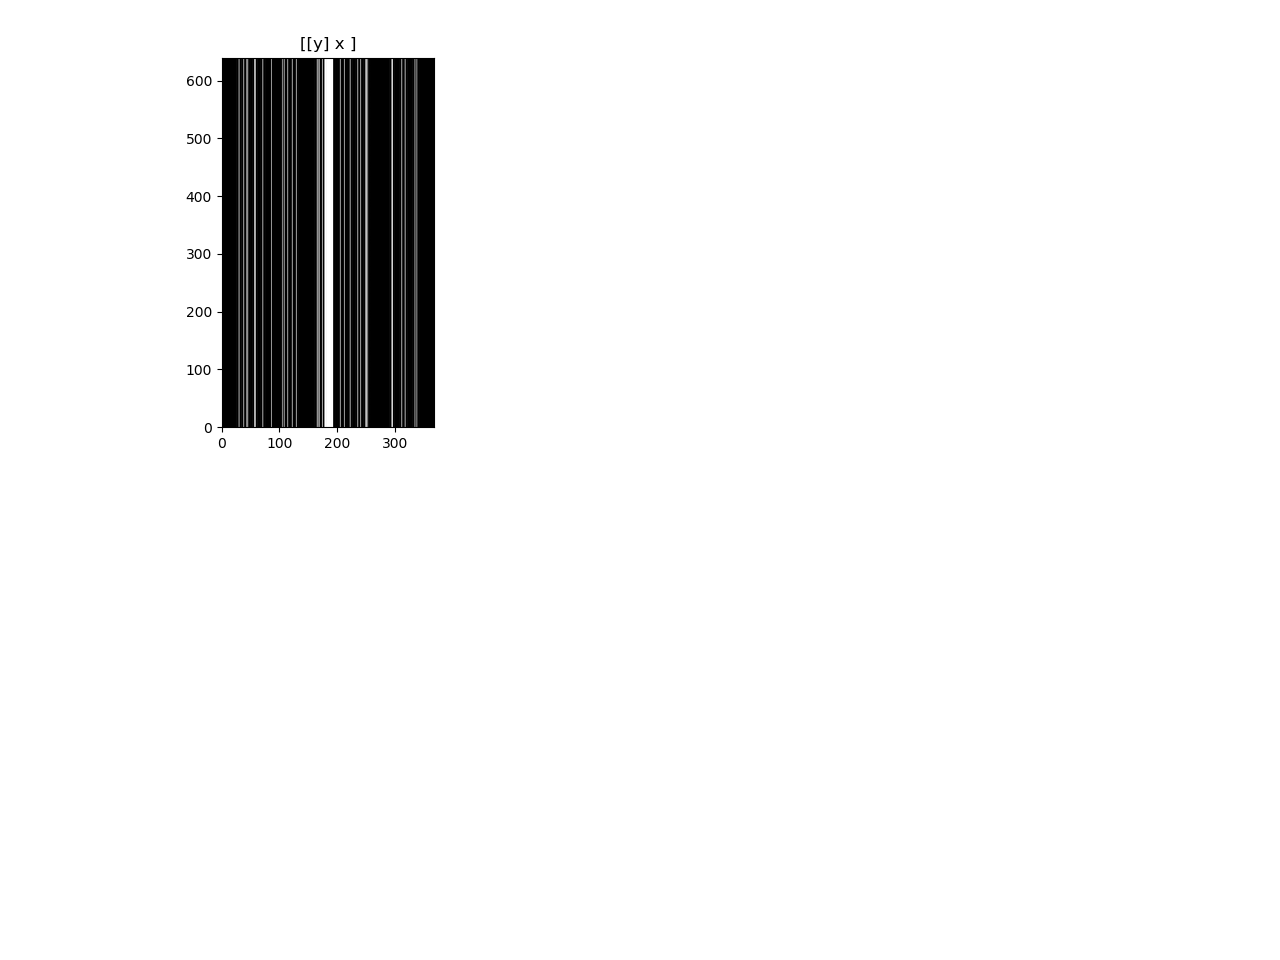

In [5]:
ImagePlot(mask);

In [6]:
ksp_slice = ksp_data[22] # Picking the middle slice (slice 22) for reconstruction

In [7]:
if pre_run:
    if acc_8:
        mdd_recon = np.load("data/out/recon/8x_mdd_recon.npy")
    else:
        mdd_recon = np.load("data/out/recon/4x_mdd_recon.npy")
else:
    subsampled_ksp_data = [ch for ch in ksp_slice*mask[None,...]] # Applying the mask to every coil, and creating a list for the recon function
    imgs_sub,mse_sub,net = pipe.multichannel_recon(subsampled_ksp_data, k = 256, kernel_size = 1, d = 5, niter = 50000, device=device, forward = True, mask = mask)
    mdd_recon = np.stack(imgs_sub)
    
    print(net)

In [8]:
gt_im = np.linalg.norm(dp.ifftc(ksp_slice), axis=0)
mdd_im = np.linalg.norm(mdd_recon, axis=0)
zfill_im  = np.linalg.norm(dp.ifftc(ksp_slice*mask), axis=0)

<IPython.core.display.Javascript object>


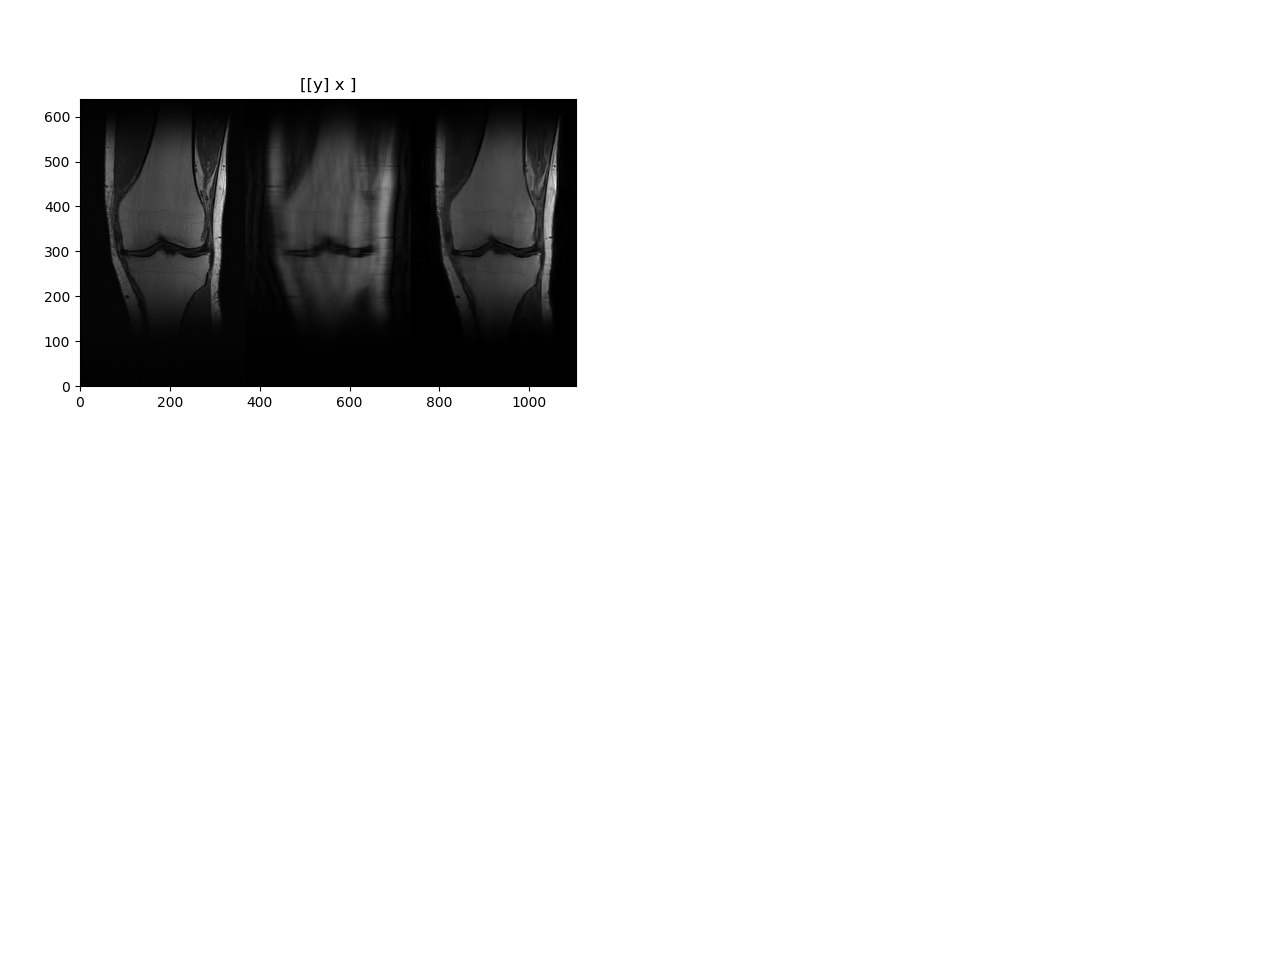

In [9]:
ImagePlot(np.hstack((gt_im, zfill_im, mdd_im)));

# PICS Reco in BART

In [10]:
if not pre_run:
    import sys, os
    try:
        bart_python_path = os.environ["TOOLBOX_PATH"] + "/python"
        sys.path.append(bart_python_path)
    except Exception as e:
        raise TypeError("Make sure you have install the BART Toolbox and have your environment variable "
                        "${TOOLBOX_PATH} appropriately set") from e
    from bart import bart

In [11]:
# You can uncomment the bottom two commands to get a better understanding of what the BART commands do
# !bart ecalib -h
# !bart pics -h

In [12]:
if not pre_run:
    y_bart = np.transpose(ksp_slice*mask[None,...],(1,2,0))
    y_bart = y_bart[:,:,None,:]
    sens = bart(1, "ecalib -m1 -S -r14", y_bart)
    pics_reco = bart(1, "pics -S -R T:7:0:0.01 -i 300", y_bart, sens)
    pics_im = abs(pics_reco)

In [13]:
if pre_run:
    if acc_8:
        pics_im = np.load("data/out/recon/8x_cs_reco.npy")
    else:
        pics_im = np.load("data/out/recon/4x_cs_reco.npy")

<IPython.core.display.Javascript object>


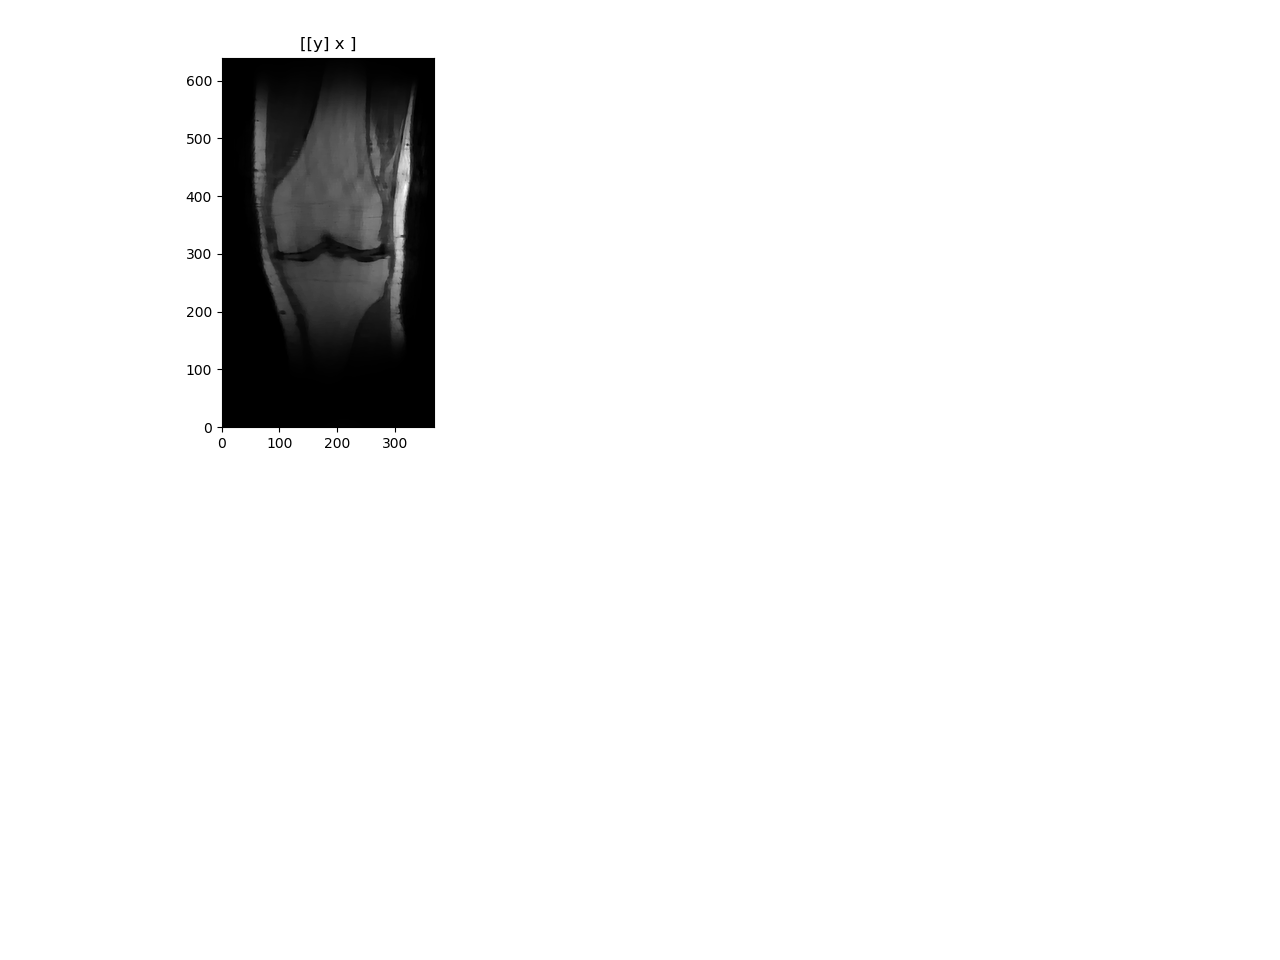

In [14]:
ImagePlot(pics_im);

# Final Figure

In [15]:
print("Zero Fill Reconstruction PSNR: {}\nPICS Reconstruction PSNR: {}\nDeep Decoder PSNR: {}".format(imstat.psnr(gt_im, zfill_im),imstat.psnr(gt_im, pics_im), imstat.psnr(gt_im, mdd_im)))

Zero Fill Reconstruction PSNR: 25.628244175712297
PICS Reconstruction PSNR: 31.953420639038086
Deep Decoder PSNR: 33.19192886352539


In [16]:
def gen_zoom_window(w, dims, shift):
    c1 = dims[0]//2+shift
    c2 = dims[1]//2+shift
    s1 = slice(c1-w//2,c1+w//2)
    s2 = slice(c2-w//2,c2+w//2)
    return s1, s2

def plot_fig(fig, vmax):
    obj = ImagePlot(fig)
    obj.vmin = 0
    obj.vmax = vmax
    obj.update_image()
    obj.fig.canvas.draw()
    return obj

In [17]:
im_row = np.hstack([gt_im, zfill_im, pics_im, mdd_im])

gt_4 = np.tile(gt_im, 4)
err_row = abs(gt_4-im_row)

s1, s2 = gen_zoom_window(80, gt_im.shape, 100)
zoom_row = np.hstack([gt_im[s1,s2], zfill_im[s1,s2], pics_im[s1,s2], mdd_im[s1,s2]])

<IPython.core.display.Javascript object>


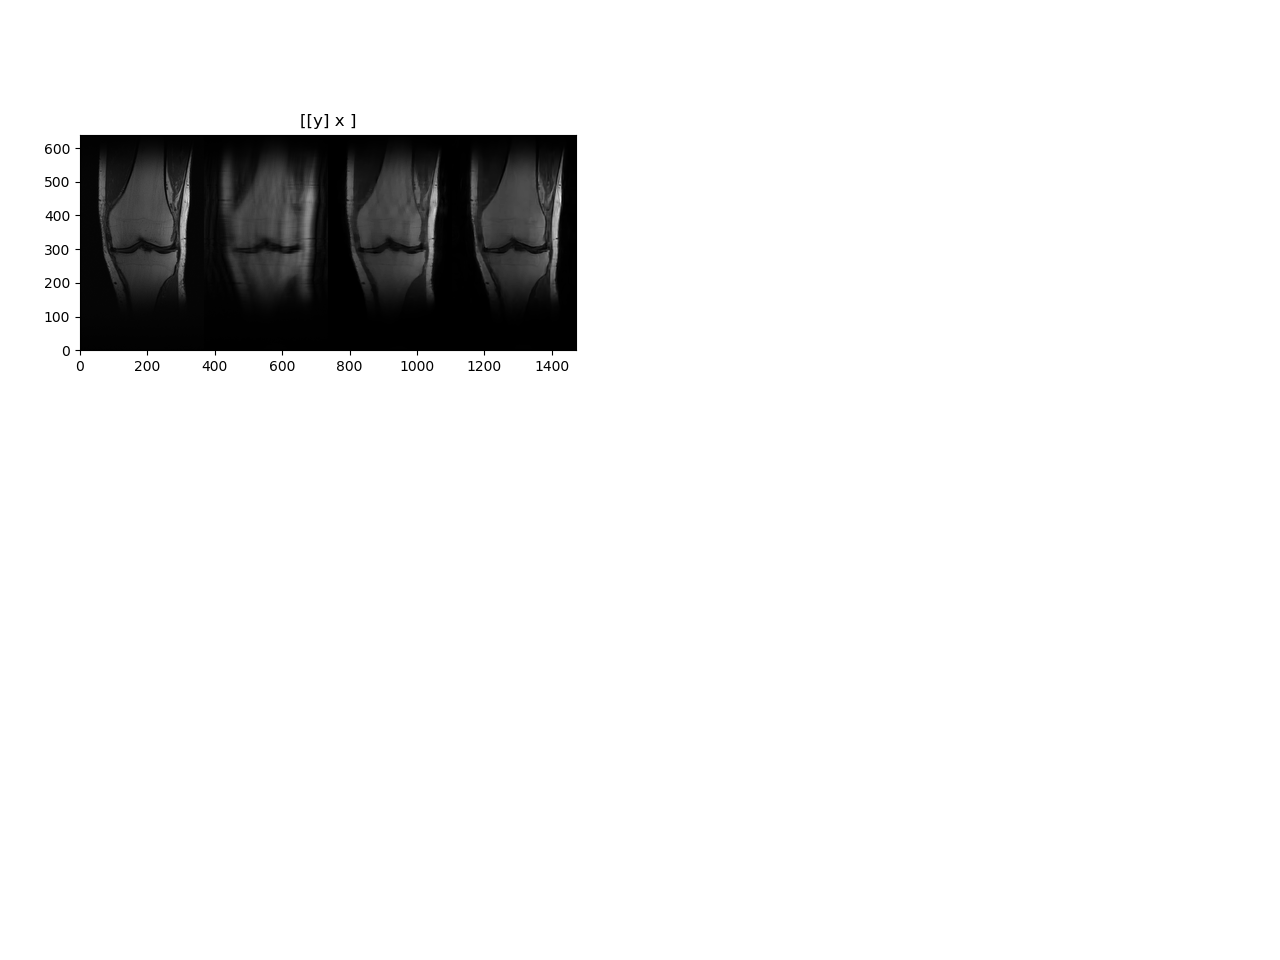

In [18]:
plot_fig(im_row, gt_im.max());

<IPython.core.display.Javascript object>


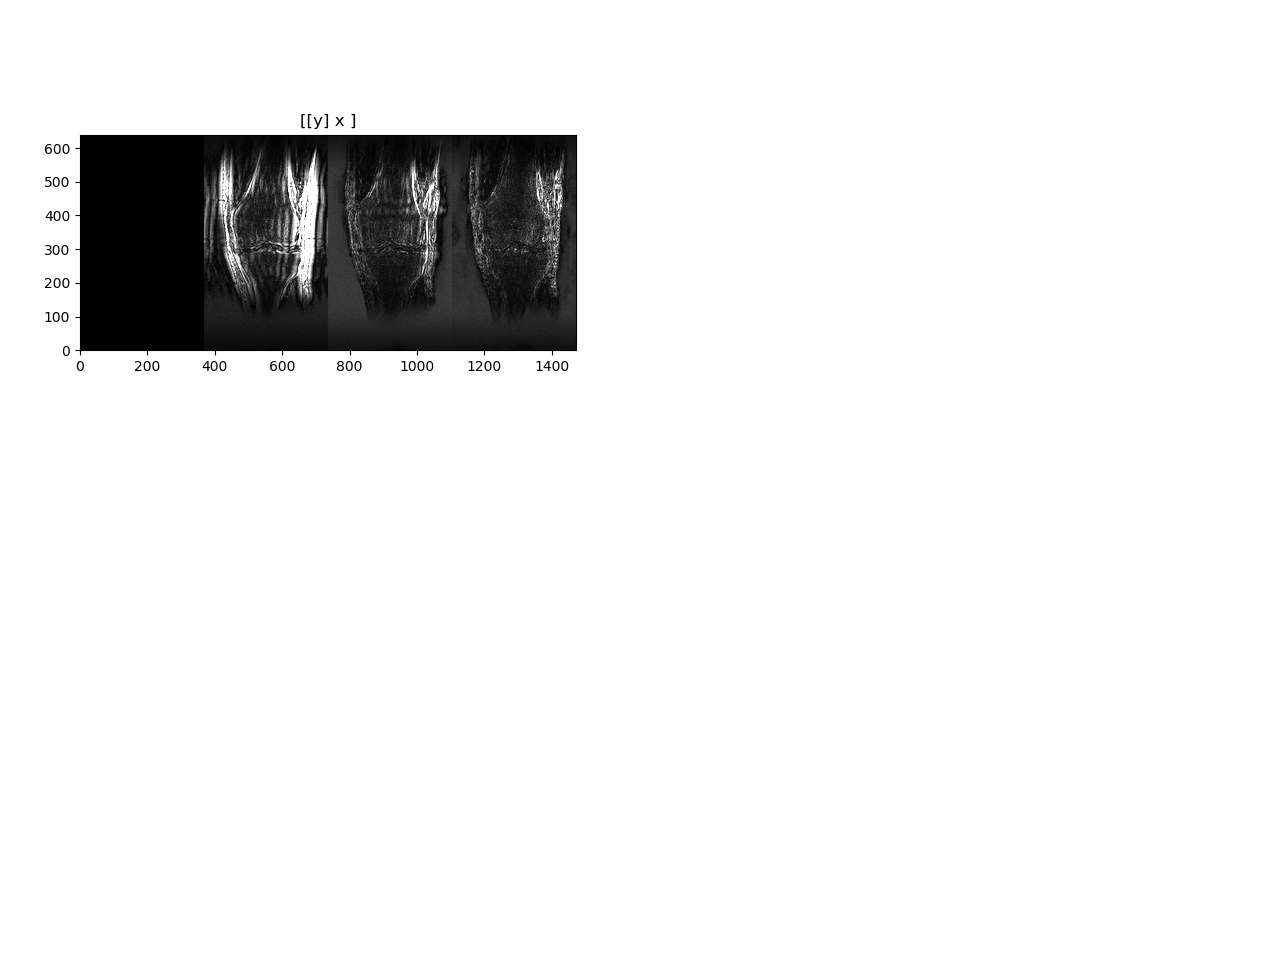

In [19]:
plot_fig(10*err_row, gt_im.max());

<IPython.core.display.Javascript object>


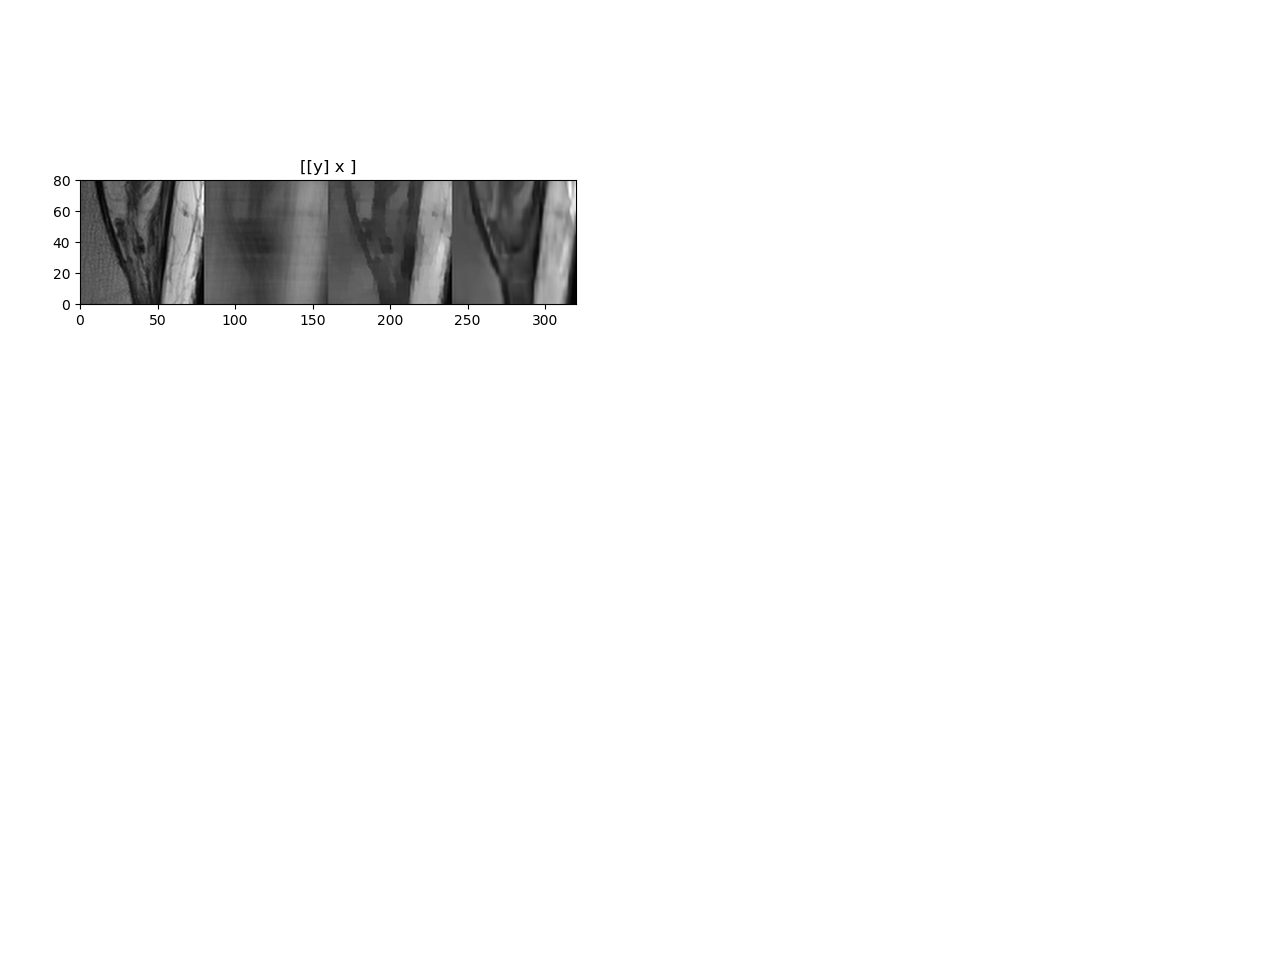

In [20]:
plot_fig(zoom_row, zoom_row.max());